# Transformata Fouriera dla obrazów cyfrowych. Filtracja w dziedzinie częstotliwości.

## Cel ćwiczenia

- Zapoznanie z wykorzystaniem transformaty Fouriera w przetwarzaniu obrazów cyfrowych.
- Zapoznanie z pojęciem F-obrazu (amplitudy i fazy).
- Zapoznanie z własnościami transformaty Fouriera.
- Zapoznanie z filtracją w dziedzinie częstotliwości.

Na jednym z poprzednich ćwiczeń zetknęliśmy się z pojęciem konwolucji.
Przykładem może być filtracja dolno i górnoprzepustowa.
Operacja ta odpowiada mnożeniu w dziedzinie częstotliwości zgodnie z zależnością:<br>
\begin{equation}
\mathcal{F}(g(x,y)*h(x,y)) = \mathcal{F}(g(x,y)) \cdot \mathcal{F}(h(x,y))
\end{equation}<br>
gdzie $\mathcal{F}$ oznacza transformatę Fouriera, a $*$ jest splotem.

Operacja filtracji w dziedzinie częstotliwości może okazać się bardziej efektywna, jeżeli operacje fft2 i ifft2 zajmą mniej czasu niż klasyczna konwolucja (zazwyczaj dla dużego obrazu, z dużą maską).

Sama filtracja w dziedzinie częstotliwości to mnożenie całego obrazu przez jedną maskę.

W przypadku filtracji w dziedzinie częstotliwości zakłada się, że obraz "zawija się" na brzegach, co może powodować pewne artefakty.

W dziedzinie częstotliwości "działają" tylko filtry określane jako liniowe.
Filtry medianowe, maksymalne, minimalne itp. nie mają swoich odpowiedników.

## Dwuwymiarowa transformata Fouriera

1. Wczytaj plik "dwieFale.bmp" w skali szarości.
Jest to obraz powstały na podstawie następującej zależności:<br>
\begin{equation}
L(m, n) = 128 + 127 \cdot \cos(\frac{2\pi m}{32}+\frac{3\pi}{4}) \cdot \cos(\frac{2\pi n}{8}-\frac{\pi}{2})
\end{equation}<br>
gdzie $m$ i $n$ są odpowiednio numerami wierszy i kolumn.
2. Do realizacji dwuwymiarowej transformaty Fouriera służy funkcja `cv2.dft`.
Wykonaj transformatę na wczytanym obrazie. W ten sposób uzyskuje się tzw. F-obraz.
3. Najniższe częstotliwości znajdują się w lewym-górnym rogu obrazu.
Dla celów wizualizacji często wykonuje się tzw. przesunięcie F-obrazu, które przesuwa niskie częstotliwości do środka.
Wykorzystaj funkcję `np.fft.fftshift`.
Jako pierwszy argument podaj wynik transformaty Fouriera.
Jako drugi argument podaj numery osi, wzdłuż których należy wykonać operację.
Pierwsza oś odnosi się do wierszy obrazu.
Druga oś odnosi się do kolumn obrazu.
Trzecia oś to część rzeczywista (`[:, :, 0]`) lub urojona (`[:, :, 1]`)
4. Wyświetl wynik transformaty.
Na wspólnym wykresie umieść obraz oryginalny, amplitudę i fazę F-obrazu.
Amplitudę i fazę wyznacz za pomocą funkcji `cv2.cartToPolar`.
Pierwszym argumentem funkcji jest część rzeczywista wyniku, a drugim urojona.
5. Dla wizualizacji oblicz logarytm dziesiętny amplitudy: `ALog = np.log10(A + 1)`.
Wyświetl go zamiast amplitudy na poprzednim wykresie.
6. Wczytaj obrazy *kolo.bmp*, *kwadrat.bmp*, *kwadrat45.bmp*, *trojkat.bmp*.
Czy analizując F-obraz można coś powiedzieć o kierunku krawędzi obiektów?
7. Sprawdź (empirycznie) poprawność stwierdzenia:
>Dwuwymiarowa transformata Fouriera jest złożeniem dwóch transformat jednowymiarowych (wykonanych np. najpierw wierszowo, a później kolumnowo). Jednowymiarowa transformata realizowana jest za pomocą funkcji fft.
>
Wykonaj najpierw transformatę po wierszach: `FRow = np.fft.fft(I, axis=0)`.
Następnie po kolumnach: `FCol = np.fft.fft(I, axis=1)`.
Porównaj tak uzyskany wynik z rezultatem działania funkcji `cv2.dft`.
Można to zrobić wizualnie lub z wykorzystaniem funkcji `cv2.absdiff`.

(-0.5, 31.5, 31.5, -0.5)

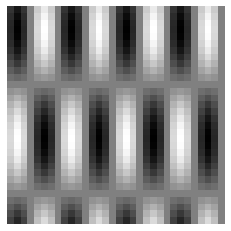

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

# Load required files
if not os.path.exists("dwieFale.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/dwieFale.bmp --no-check-certificate
if not os.path.exists("kolo.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/kolo.bmp --no-check-certificate
if not os.path.exists("kwadrat.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/kwadrat.bmp --no-check-certificate
if not os.path.exists("kwadrat45.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/kwadrat45.bmp --no-check-certificate
if not os.path.exists("kwadratKL.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/kwadratKL.bmp --no-check-certificate
if not os.path.exists("kwadratS.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/kwadratS.bmp --no-check-certificate
if not os.path.exists("kwadratT.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/kwadratT.bmp --no-check-certificate
if not os.path.exists("lena.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/lena.bmp --no-check-certificate
if not os.path.exists("trojkat.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/trojkat.bmp --no-check-certificate

I_Fale = cv2.imread('dwieFale.bmp', cv2.IMREAD_GRAYSCALE)

figFale, axsFale = plt.subplots()

axsFale.imshow(I_Fale, 'gray', vmin=0, vmax=256)
axsFale.axis('off')

In [14]:
def display_fourier(Image):
    dft = cv2.dft(np.float32(Image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude, phase = cv2.cartToPolar(dft_shift[:, :, 0], dft_shift[:, :, 1])
    A = np.log10(magnitude + 1)
    
    f, a = plt.subplots(1, 3, figsize=(15, 15))
    a[0].imshow(Image, 'gray')
    a[1].imshow(A, 'gray')
    a[2].imshow(phase, 'gray')
    plt.show()
    return dft_shift

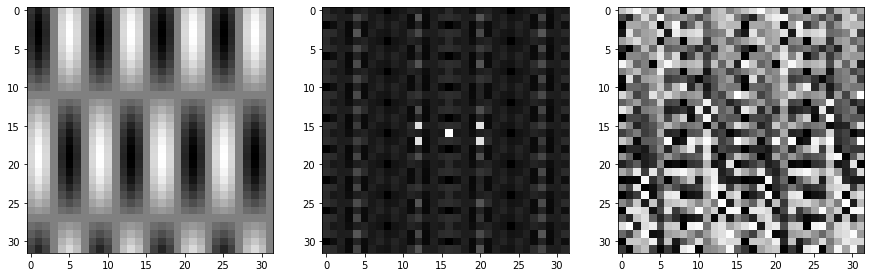

In [12]:
display_fourier(I_Fale)

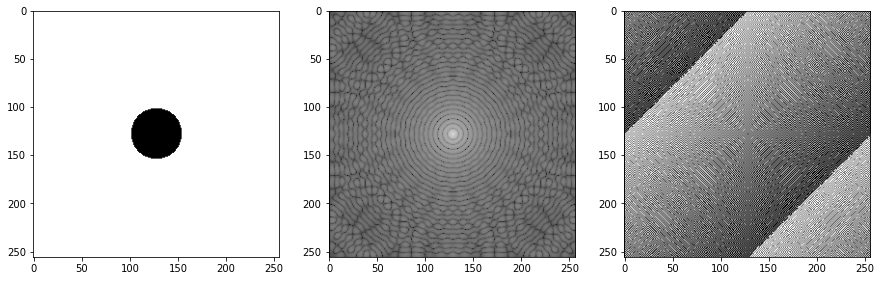

In [13]:
I = cv2.imread('kolo.bmp', cv2.IMREAD_GRAYSCALE)
display_fourier(I)

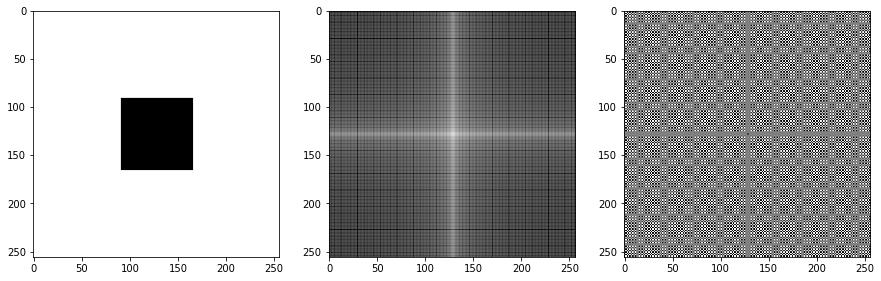

In [23]:
I = cv2.imread('kwadrat.bmp', cv2.IMREAD_GRAYSCALE)
display_fourier(I)

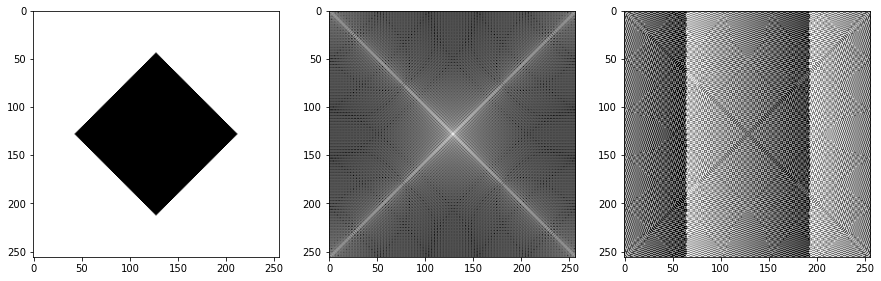

In [24]:
I = cv2.imread('kwadrat45.bmp', cv2.IMREAD_GRAYSCALE)
display_fourier(I)

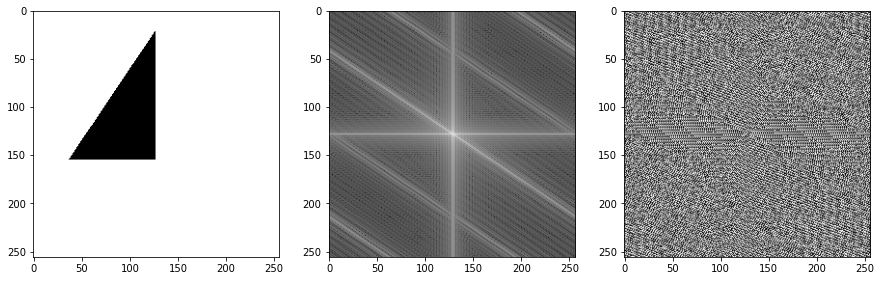

In [26]:
I = cv2.imread('trojkat.bmp', cv2.IMREAD_GRAYSCALE)
display_fourier(I)

In [101]:
FRow = np.fft.fft(I, axis=0)
FCol = np.fft.fft(FRow, axis=1)
shifted1 = np.fft.fftshift(FCol)
m1, p1 = cv2.cartToPolar(shifted1[:, :, 0], shifted1[:, :, 1])

I2 = np.fft.fft2(I)
shifted2 = np.fft.fftshift(I2)
m2, p2 = cv2.cartToPolar(shifted2[:, :, 0], shifted2[:, :, 1])

dif1 = cv2.absdiff(m1, m2)
dif2 = cv2.absdiff(p1, p2)

f, a = plt.subplots(2, 3, figsize=(15, 15))
a[0,0].imshow(m1, 'gray')
a[0,1].imshow(m2, 'gray')
a[0,2].imshow(dif1, 'gray')
a[1,0].imshow(p1, 'gray')
a[1,1].imshow(p2, 'gray')
a[1,2].imshow(dif2, 'gray')
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [15]:
I2 = np.fft.fft2(I)
I3 = np.fft.fft(np.fft.fft(I, axis=0), axis=1)

print(I2)
print("next")
print(I3)

[[16159860.        +0.00000000e+00j   523647.53411293+6.42644466e+03j
   -444819.07690269-1.09196954e+04j ...   330970.95039375-1.21903819e+04j
   -444819.07690269+1.09196954e+04j   523647.53411293-6.42644466e+03j]
 [  523647.53411293+6.42644466e+03j  -496380.42944613-1.21854556e+04j
    420289.59284972+1.54801824e+04j ...  -310885.53530741+7.63181153e+03j
    420542.9121749 -5.16109707e+03j  -496529.97499137+2.27373675e-13j]
 [ -444819.07690269-1.09196954e+04j   420289.59284972+1.54801824e+04j
   -352099.66725122-1.72975475e+04j ...   254738.25602717-3.12626566e+03j
   -352524.29820715+2.04636308e-12j   420542.9121749 +5.16109707e+03j]
 ...
 [  330970.95039375-1.21903819e+04j  -310885.53530741+7.63181153e+03j
    254738.25602717-3.12626566e+03j ...  -174172.92920072+1.28477671e+04j
    254278.01405612-1.56219137e+04j  -310604.60836587+1.52590259e+04j]
 [ -444819.07690269+1.09196954e+04j   420542.9121749 -5.16109707e+03j
   -352524.29820715-4.09272616e-12j ...   254278.01405612-1.56219

## Własności dwuwymiarowej transformaty Fouriera

1. Zbadaj jak zmienia się F-obraz (amplituda i faza) podczas następujących operacji: translacja, rotacja, zmiana rozmiaru, kombinacja liniowa.
Wykorzystaj stworzony wcześniej kod.
2. Do badania translacji wykorzystaj obrazy *kwadrat.bmp* i *kwadratT.bmp*.
3. Przy badaniu rotacji wykorzystaj obrazy *kwadrat.bmp* i *kwadrat45.bmp*.
4. Przy badaniu zmiany rozmiaru wykorzystaj obrazy *kwadrat.bmp* i *kwadratS.bmp*.
5. Przy badaniu kombinacji liniowej wykorzystaj obrazy *kwadrat.bmp*, *kwadrat45.bmp* i *kwadratKL.bmp*.

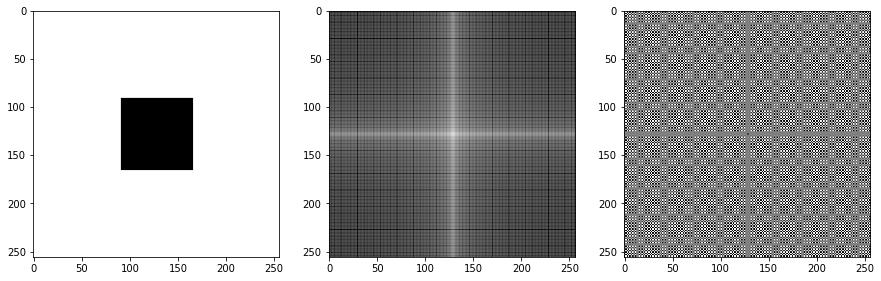

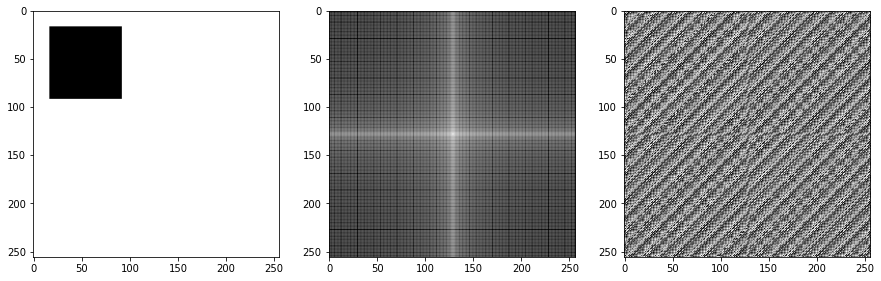

In [36]:
#translacja
I = cv2.imread('kwadrat.bmp', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('kwadratT.bmp', cv2.IMREAD_GRAYSCALE)
display_fourier(I)
display_fourier(I2)

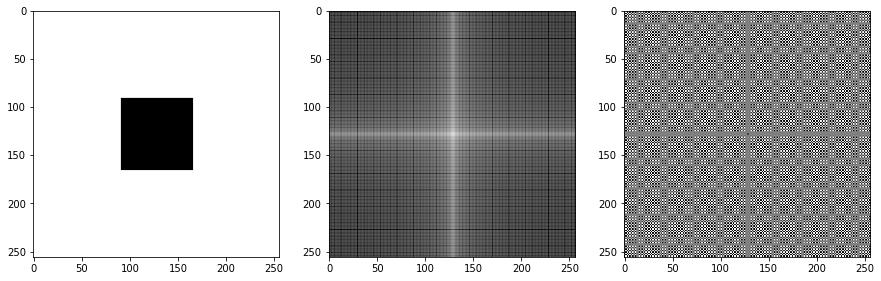

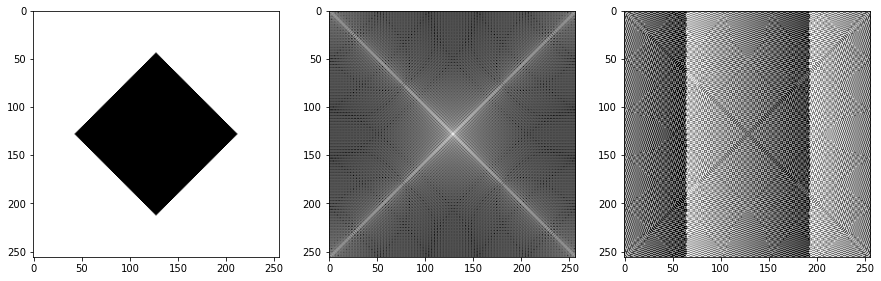

In [37]:
#rotacja
I = cv2.imread('kwadrat.bmp', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('kwadrat45.bmp', cv2.IMREAD_GRAYSCALE)
display_fourier(I)
display_fourier(I2)

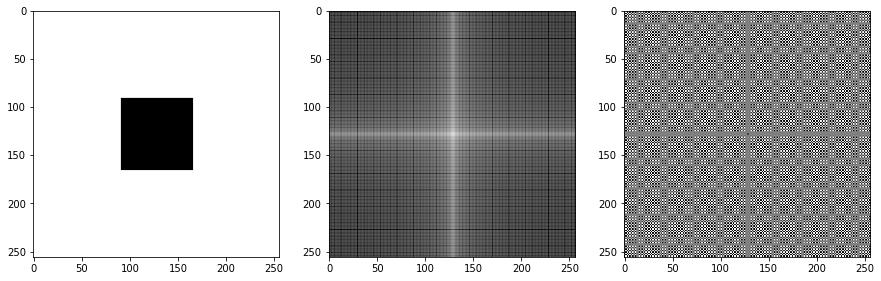

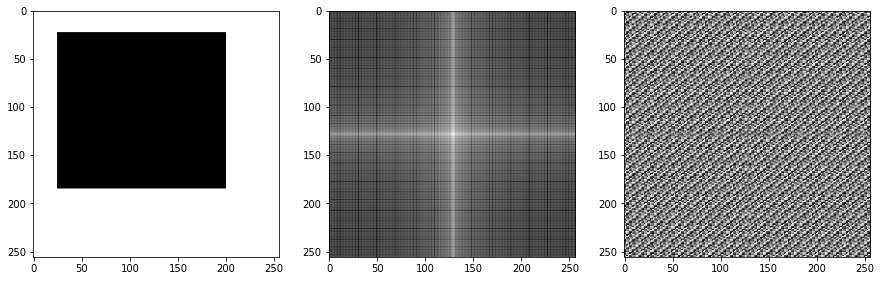

In [38]:
#zmiana rozmiaru
I = cv2.imread('kwadrat.bmp', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('kwadratS.bmp', cv2.IMREAD_GRAYSCALE)
display_fourier(I)
display_fourier(I2)

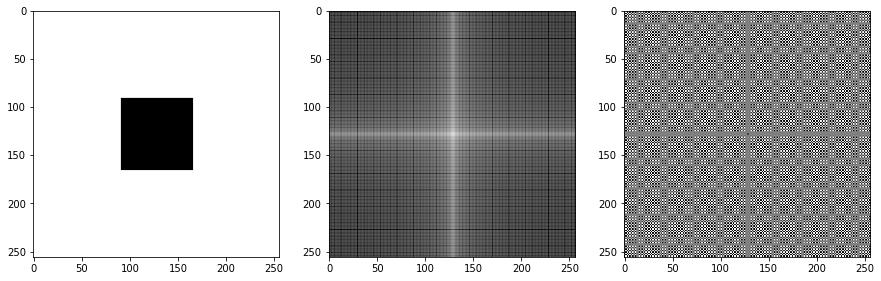

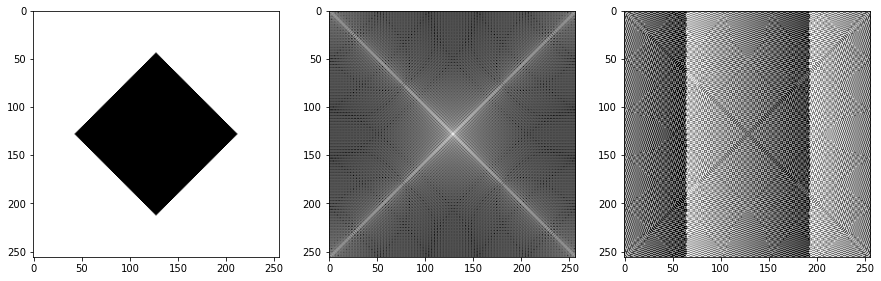

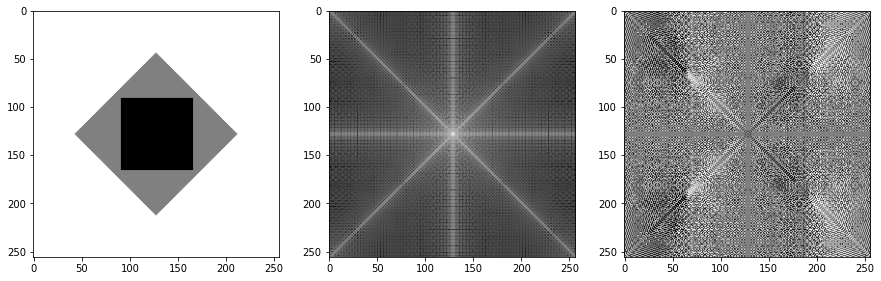

In [39]:
I = cv2.imread('kwadrat.bmp', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('kwadrat45.bmp', cv2.IMREAD_GRAYSCALE)
I3 = cv2.imread('kwadratKL.bmp', cv2.IMREAD_GRAYSCALE)
display_fourier(I)
display_fourier(I2)
display_fourier(I3)

## Odwrotna dwuwymiarowa transformata Fouriera

1. Wykorzystaj stworzony wcześniej kod. Wybierz dowolny obraz np "kolo.bmp".
2. Przed realizacją odwrotnego przekszałcenia należy wykonać odwrotne przesunięcie.
Wykorzystaj funkcję `np.fft.ifftshift`.
Pierwszym argumentem jest wynik transformaty Fouriera.
Drugim argumentem są numery osi, wzdłuż których należy wykonać operację.
3. Wykonaj odwrotną transformatę Fouriera za pomocą funkcji `cv2.idft`.
4. Wyświetl wynik.
Sprawdź (wizualnie i poprzez odjęcie) czy obraz oryginalny i po przekształceniach są takie same.

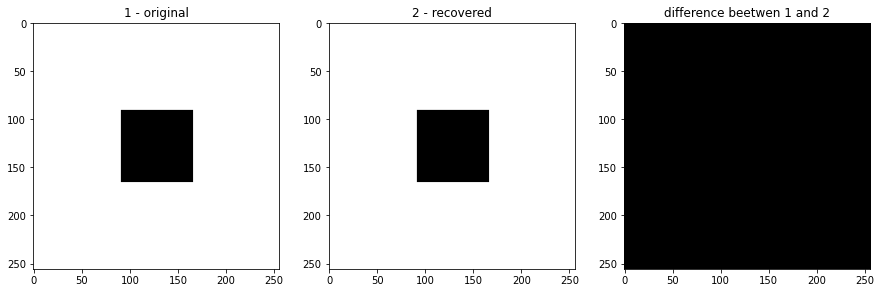

In [36]:
I = cv2.imread('kwadrat.bmp', cv2.IMREAD_GRAYSCALE)
dft = cv2.dft(np.float32(I), flags=cv2.DFT_COMPLEX_OUTPUT)
shifted = np.fft.fftshift(dft)

unshifted = np.fft.ifftshift(shifted)

I2a = cv2.idft(unshifted)
I2a = cv2.magnitude(I2a[:, :, 0], I2a[:, :, 1])

I2 = np.zeros(I2a.shape)
I2 = cv2.normalize(I2a, I2, 0, 255, cv2.NORM_MINMAX)
I2 = np.round(I2)

I3 = cv2.absdiff(np.float32(I), np.float32(I2))

f, a = plt.subplots(1, 3, figsize=(15, 15))
a[0].set_title("1 - original")
a[0].imshow(I, 'gray')
a[1].set_title("2 - recovered")
a[1].imshow(I2, 'gray')
a[2].set_title("difference beetwen 1 and 2")
a[2].imshow(I3, 'gray')
plt.show()

## Filtracja obrazu w dziedzinie częstotliwości

1. Wczytaj obraz "lena.bmp" w skali szarości.
Wykonaj transformatę Fouriera. Wykorzystaj stworzony poprzednio kod.
Wyświetl obraz oryginalny, amplitudę (w skali logarytmicznej) i fazę.
2. Przeprowadź filtrację dolnoprzepustową - usuń górne częstotliwości.
Dla przesuniętego F-obrazu niskie częstotliwości leżą w jego centrum.
3. Na początku stwórz filtr "kołowy", dolnoprzepustowy.
Należy wykenerować macierze opisujące przestrzeń w dziedzinie częstotliwości.
Ich rozmiar musi być taki sam jak rozmiar przetwarzanego obrazu.
        lenaSize = I_Lena.shape
        FSpaceRows = 2 * np.fft.fftshift(np.fft.fftfreq(lenaSize[0]))
        FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, lenaSize[1]]))
        FSpaceCols = 2 * np.fft.fftshift(np.fft.fftfreq(lenaSize[1]))
        FSpaceColsM = np.outer(np.ones([1, lenaSize[0]]), FSpaceCols)
Powyższy kod wygeneruje dwie znormalizowane macierze częstotliwości: *FSpaceRowsM* i *FSpaceColsM*.
Następnie należy wyznaczyć macierz zawierającą "odległość" od składowej stałej.
        FreqR = np.sqrt(np.square(FSpaceRowsM) + np.square(FSpaceColsM))
4. Teraz należy wybrać interesujący zakres.
Tu można zdefiniować typ filtru (dolno, górno, pasmowoprzepustowy).
        FilterF = FreqR <= 0.1
Filtr należy zwizualizować:
        figFilter = plt.figure()
        axsFilter = figFilter.add_subplot(projection='3d')
        axsFilter.plot_surface(FSpaceRowsM, FSpaceColsM, FilterF, rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)
        figFilter.show()
4. Wykonaj właściwą filtrację, czyli mnożenie F-obrazu przez filtr Hd.
Trzeba pamiętać, że F-obraz ma 2 kanały.
By mnożenie było możliwe należy więc powielić filtr również na 2 kanały.
        FilterF3 = np.repeat(FilterF[:, :, np.newaxis], 2, axis=2)
5. Wykonaj operację odwrotnego przesunięcia i odwrotnej transformaty.
Oblicz wartość bezwzględną wyniku. Wykorzystaj funkcję `cv2.magnitude`.
Pierwszym argementem jest część rzeczywista.
Drugim argumentem jest część urojona.
Wynik wyświetl.
6. Poeksperymentuj z rozmiarem filtru (promieniem).
Zaimplementuj filtr górnoprzepustowy (zmiana znaku przy warunku na odległość) oraz pasmowoprzepustowy (dwa warunki na promień połączone operatorem AND '&' ).
Wykonaj co najmniej trzy filtry i wyświetl wyniki.
7. W ten sposób zaimplementowana filtracja wprowadza pewne artefakty w postaci "pierścieni" wokół krawędzi.
Zapobiec temu zjawisku można zapobiec odpowiednio "modelując" filtr.
W tym celu wykorzystać należy okna, np. Hamminga, Hanninga, Chebysheva (znane z przetwarzania sygnałów 1D).

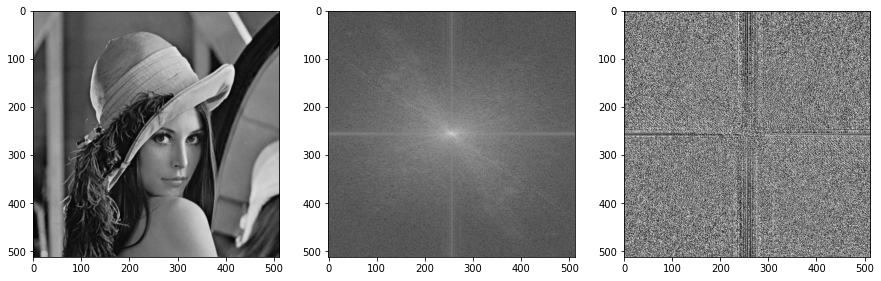

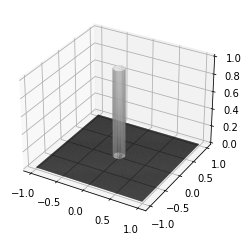

In [73]:
I = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)
dft_shift = display_fourier(I)
lenaSize = I.shape
FSpaceRows = 2 * np.fft.fftshift(np.fft.fftfreq(lenaSize[0]))
FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, lenaSize[1]]))
FSpaceCols = 2 * np.fft.fftshift(np.fft.fftfreq(lenaSize[1]))
FSpaceColsM = np.outer(np.ones([1, lenaSize[0]]), FSpaceCols)

FreqR = np.sqrt(np.square(FSpaceRowsM) + np.square(FSpaceColsM))

FilterF = FreqR <= 0.1
figFilter = plt.figure()
axsFilter = figFilter.add_subplot(projection='3d')
axsFilter.plot_surface(FSpaceRowsM, FSpaceColsM, FilterF, rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)

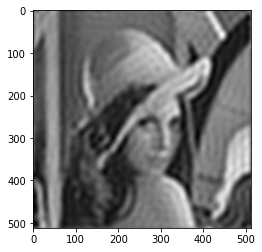

In [84]:
FilterF3 = np.repeat(FilterF[:, :, np.newaxis], 2, axis=2)
fshift = dft_shift * FilterF3
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.imshow(img_back, 'gray')

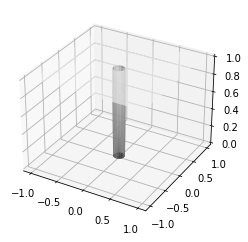

In [78]:
FilterHigh = FreqR >= 0.1
figFilter = plt.figure()
axsFilter = figFilter.add_subplot(projection='3d')
axsFilter.plot_surface(FSpaceRowsM, FSpaceColsM, FilterHigh, rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)

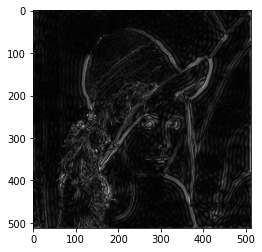

In [80]:
FilterHigh3 = np.repeat(FilterHigh[:, :, np.newaxis], 2, axis=2)
fshift = dft_shift * FilterHigh3
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.imshow(img_back, 'gray')

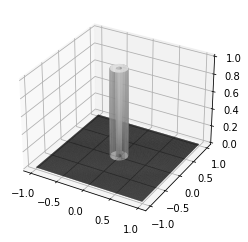

In [86]:
FilterPasmo = (FreqR >= 0.05) & (FreqR <= 0.15)
figFilter = plt.figure()
axsFilter = figFilter.add_subplot(projection='3d')
axsFilter.plot_surface(FSpaceRowsM, FSpaceColsM, FilterPasmo, rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)

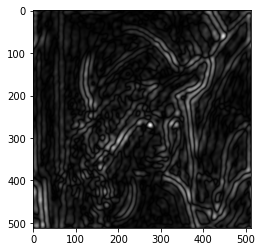

In [87]:
FilterPasmo3 = np.repeat(FilterPasmo[:, :, np.newaxis], 2, axis=2)
fshift = dft_shift * FilterPasmo3
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.imshow(img_back, 'gray')

## Implementacja wyszukiwania wzorca za pomocą FFT

1. Wczytaj w skalis szarości i wyświetl obrazy *literki.bmp* i *wzorA.bmp*.
2. Wyznacz transformatę Fouriera obrazu *literki.bmp*.
3. Obróć drugi obraz o $180^\circ$.
Zastosuj funkcję `np.rot90`.
Pierwszym argumentem jest obracana macierz, a drugim liczba obrotów o $90^\circ$.
4. Należy wyznaczyć transformatę Fouriera obróconego obrazu w taki sposób, żeby miałą ona taki sam rozmiar jak pierwszy obraz.
W tym celu należy zastosować *Zero Padding*.
Operacja ta polega na uzupełnieniu obrazu zerami do oczekiwanego rozmiaru.
Uzupełnij obraz zerami z **prawej** strony i z **dołu**.
W tym celu należy wykorzystać funkcję `cv2.copyMakeBorder`.
    - Pierwszym argumentem jest obraz wejściowy.
    - Drugim argumentem jest liczba wierszy u góry.
    - Trzecim argumentem jest liczba wierszy u dołu.
    - Czwartym argumentem jest liczba kolumn z lewej.
    - Piątym argumentem jest liczba kolumn z prawej.
    - Szóstym argumentem jest flaga typu wypełnienia.
    Dla stałej wartości podaj `cv2.BORDER_CONSTANT`.
    - Siódmym argementem jest wartość pikseli w ramce.
    Przekaż `value=0`.
5. Wyznacz transformatę Fouriera obrazu stworzonego w poprzednim punkcie.
6. Wyniki obu transformat należy przekonwertować do liczb zespolonych.
Obecnie jest to dwukanałowa macierz.
Pierwszy kanał odpowiada za część rzeczywistą.
Drugi kanał odpowiada za część urojoną.
Aby to osiągnąć wystarczy wykonać działanie:
        Complex = Real + Imag * 1j
7. Przemnóż ze sobą zespolone wyniki transformat.
8. Wynik należy powrotnie przekształcić do dwukanałowej macierzy.
Aby to zrobić wykonaj operację:
        CompMat = cv2.merge([np.real(Complex), np.imag(Complex)])
9. Wykonaj odwroną transformatę Fouriera.
Dodaj flagę `flags=cv2.DFT_COMPLEX_INPUT`.
10. Oblicz wartość bezwzględną wyniku.
11. Wykonaj morfologiczną operację **Top-Hat**, by znaleźć maksima.
Operacja ta zostanie dokłądniej wyjaśniona w kolejnym ćwiczenia.
W tym celu wykorzystaj operację:
        cv2.morphologyEx(correlation, cv2.MORPH_TOPHAT, np.ones((3, 3), np.uint8))
12. Wyświetl obok siebie obraz wejściowy i wynik wykonanych operacji.
Czy możesz wskazać położenie wzoru na podstawie drugiego obrazu?

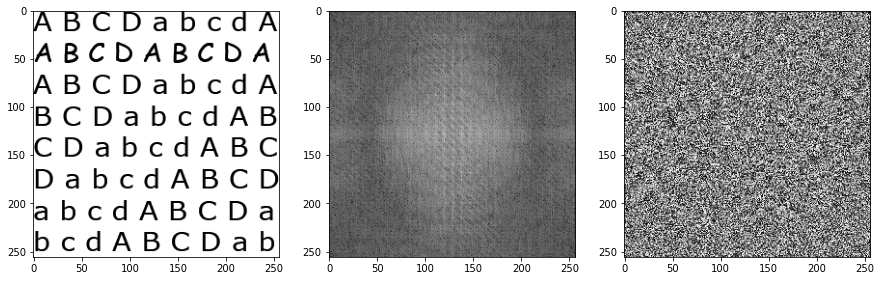

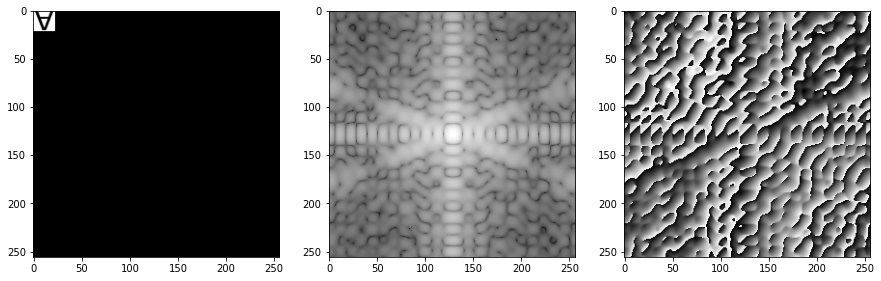

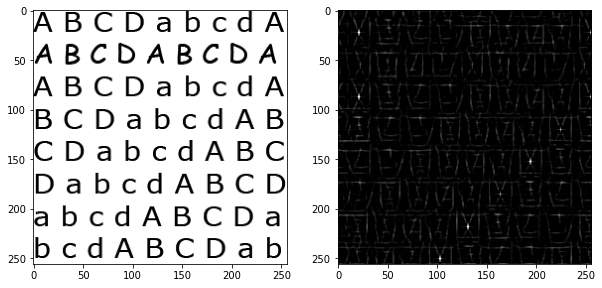

In [38]:
I = cv2.imread('literki.bmp', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('wzorA.bmp', cv2.IMREAD_GRAYSCALE)
F1 = display_fourier(I)

I2 = np.rot90(I2, 2)
row_padding = I.shape[0] - I2.shape[0]
col_padding = I.shape[1] - I2.shape[1]
I2 = cv2.copyMakeBorder(I2, 0, row_padding, 0, col_padding, cv2.BORDER_CONSTANT, value=0)
F2 = display_fourier(I2)

Complex1  = F1[:, :, 0] + F1[:, :, 1] * 1j
Complex2  = F2[:, :, 0] + F2[:, :, 1] * 1j

Complex3 = Complex1 * Complex2
CompMat = cv2.merge([np.real(Complex3), np.imag(Complex3)])
f_ishift = np.fft.ifftshift(CompMat)
I3 = cv2.idft(f_ishift, flags=cv2.DFT_COMPLEX_INPUT)
#I3 = cv2.magnitude(I3[:,:,0], I3[:,:,1])
I3 = np.abs(I3)

I4 = cv2.morphologyEx(I3, cv2.MORPH_TOPHAT, np.ones((3, 3), np.uint8))
I4 = cv2.magnitude(I4[:, :, 0], I4[:, :, 1])

f, a = plt.subplots(1, 2, figsize=(10, 15))
a[0].imshow(I, 'gray')
a[1].imshow(I4, 'gray')